# Medical Appointment No Shows Prediction

## Data Cleaning 
Goal: Fix errors in the raw data and create useful features for the model.

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df=pd.read_csv("[RAW] KaggleV2-May-2016.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [5]:
# Renaming misspelled columns and fixing others
df = df.rename(columns = {
    "Hipertension" : "Hypertension" , 
    "Handcap" : "Handicap", 
    "PatientID" : "Patient ID", 
    "AppointmentID" : "Appointment ID",
    "No-show" : "No_show",
    "ScheduledDay" : "Scheduled_Day",
    "AppointmentDay" : "Appointment_Day"
})

In [6]:
# Updating the data types of columns like 'Scheduled Day', and 'Appointment Day'
df['Scheduled_Day'] = pd.to_datetime(df['Scheduled_Day'])
df['Appointment_Day'] = pd.to_datetime(df['Appointment_Day']).dt.normalize()


In [7]:
# Feature engineering

df['Waiting_Days'] = (df['Appointment_Day'] - df['Scheduled_Day']).dt.days
df['Week_Day'] = df['Appointment_Day'].dt.day_name()

In [8]:
df = df[df['Age'] >= 0] # Remove negative age
df = df[df['Waiting_Days'] >= 0] # Remove negative waiting days (appointments on the same days or before the scheduled day)

In [9]:
df.duplicated().sum() #Checking for duplicates

np.int64(0)

## Exploratory Data Analysis 
Goal: Understand the patterns before modeling
- Target Distribution
- Waiting Days vs. No-Show: Do people wait longer tend to miss appointments? (Usually, yes).
- SMS Received vs. No-Show: Does receiving a text reduce no-shows? (Yes)
- Age Distribution: Are younger or older people more likely to miss? (Younger miss more)

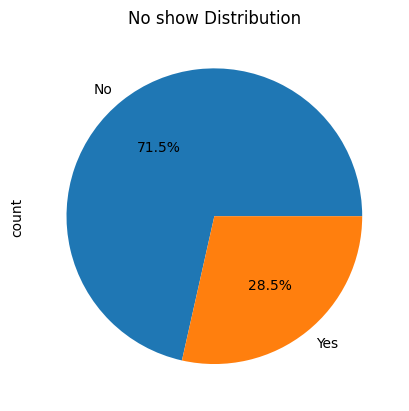

In [10]:
df['No_show'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("No show Distribution")
plt.show()

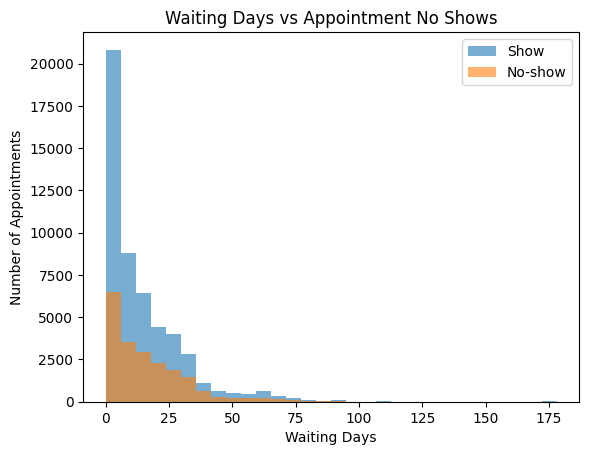

In [11]:
show = df[df['No_show'] == 'No']['Waiting_Days']
no_show = df[df['No_show'] == 'Yes']['Waiting_Days']

plt.figure()
plt.hist(show, bins=30, alpha=0.6, label='Show')
plt.hist(no_show, bins=30, alpha=0.6, label='No-show')
plt.xlabel('Waiting Days')
plt.ylabel('Number of Appointments')
plt.title('Waiting Days vs Appointment No Shows')
plt.legend()
plt.show()

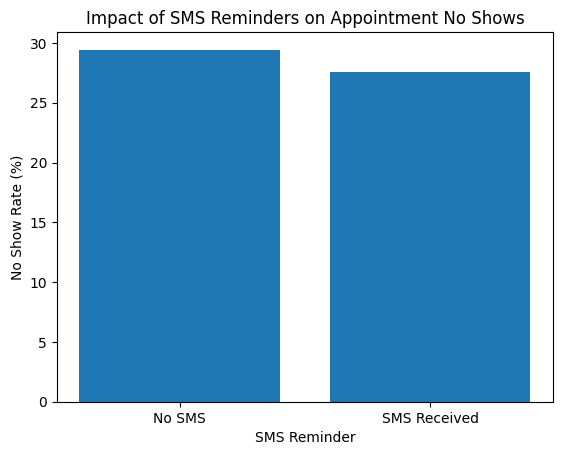

In [12]:
# Calculate no-show rates by SMS status
sms_group = df.groupby('SMS_received')['No_show'].value_counts(normalize=True).unstack()

# Extract no-show percentages
no_show_rates = sms_group['Yes'] * 100

plt.figure()
plt.bar(['No SMS', 'SMS Received'], no_show_rates)

plt.xlabel('SMS Reminder')
plt.ylabel('No Show Rate (%)')
plt.title('Impact of SMS Reminders on Appointment No Shows')
plt.show()

C:\Users\darsh\AppData\Local\Temp\ipykernel_292\2476850647.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('Age_group')['No_show']


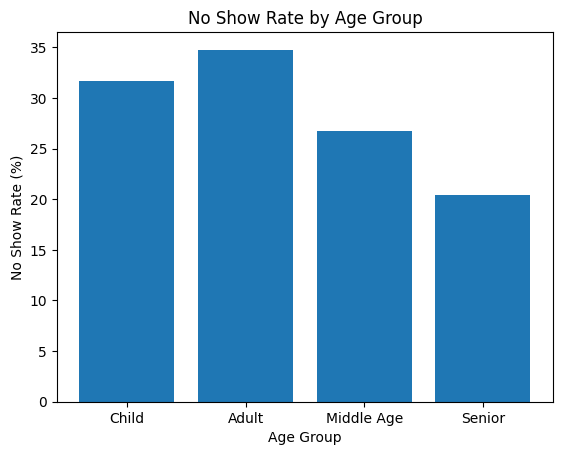

In [13]:
bins = [0, 12, 35, 60, 100]
labels = ['Child', 'Adult', 'Middle Age', 'Senior']

df['Age_group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)

age_no_show_rate = (
    df.groupby('Age_group')['No_show']
    .apply(lambda x: (x == 'Yes').mean() * 100)
)

plt.figure()
plt.bar(age_no_show_rate.index, age_no_show_rate.values)

plt.xlabel('Age Group')
plt.ylabel('No Show Rate (%)')
plt.title('No Show Rate by Age Group')
plt.show()

In [14]:
# df.to_csv('CLEANED Medical Appointment No-Shows.csv') 

## Model Preparation


In [15]:
from sklearn.model_selection import train_test_split

features = ['Age', 'Scholarship', 'Hypertension', 'Diabetes', 
            'Alcoholism', 'Handicap', 'SMS_received', 'Waiting_Days', 
            'Gender', 'Week_Day']

X = df[features]
y = df['No_show']

# One-Hot Encoding
X = pd.get_dummies(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Training
Goal: Train a Decision Tree to predict no-shows.

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

model = DecisionTreeClassifier(max_depth=5, random_state=42) # limiting depth prevents overfitting
model.fit(X_train, y_train)

preds = model.predict(X_test)

accuracy = accuracy_score(y_test, preds)
report = classification_report(y_test, preds)

cm = confusion_matrix(y_test, preds)

print("Accuracy:", accuracy)
print("\nClassification Report:", '\n', report)
print("\nConfusion Matrix:", '\n', cm) 


Accuracy: 0.7158143413007226

Classification Report: 
               precision    recall  f1-score   support

          No       0.72      1.00      0.83     10301
         Yes       0.51      0.01      0.02      4091

    accuracy                           0.72     14392
   macro avg       0.61      0.50      0.43     14392
weighted avg       0.66      0.72      0.60     14392


Confusion Matrix: 
 [[10259    42]
 [ 4048    43]]


The model was able to get a good amount of true positives and false negatives as seen in the confusion matrix, making it reliable.

In [19]:
importances = model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

importance_df
# importance_df.to_csv('importance_df.csv')

,Feature,Importance
0,Age,0.556549
7,Waiting_Days,0.290532
6,SMS_received,0.096699
4,Alcoholism,0.022684
1,Scholarship,0.017834
3,Diabetes,0.010276
9,Gender_M,0.003534
11,Week_Day_Monday,0.001893
5,Handicap,0.000000
2,Hypertension,0.000000


This table showcases how `Age` and `Waiting_Days` contributed the most to the model's prediction. These don't show causation (like coefficients in Logistic Regression), rather what needs to supposedly focused on when trying to reduce no-show rates.